In [1]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [38]:
patient = "AYWIEKR"
mr = "25"
n = 10
mr_values = [10, 20, 30, 40, 50]

df_full = pd.read_csv(f'RHR/{patient}/Anomalies/{patient}_offline_anomalies.csv', usecols=[2], header=None)
dfs_miss = {}
for mr_value in mr_values:
    dfs_miss[mr_value] = {}
    for i in range(1, n + 1):
        file_path = f'RHR/{patient}/Anomalies/MCAR/{mr_value}/{patient}_offline_anomalies_MCAR_{mr_value}_{i}.csv'
        if os.path.getsize(file_path) > 0:
            dfs_miss[mr_value][i] = pd.read_csv(file_path, usecols=[2], header=None)
        else:
            print(f"O arquivo {file_path} está vazio")

Exibindo o PDF: RHR/A1K5DRI/Figures/A1K5DRI_offline.pdf


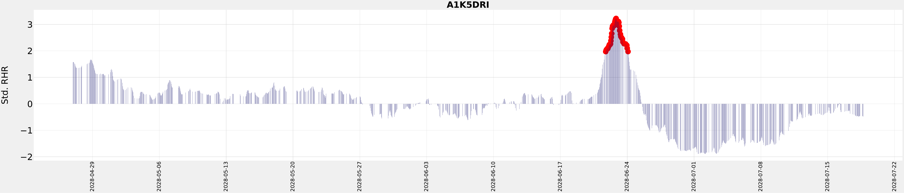

Exibindo o PDF: RHR/A1K5DRI/Figures/MCAR/50/A1K5DRI_offline_MCAR_50_1.pdf


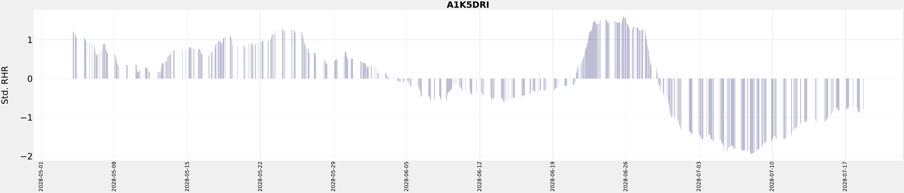

In [3]:
from IPython.display import display
from PIL import Image as PILImage
from io import BytesIO
from pdf2image import convert_from_path

# Listar arquivos PDF no diretório especificado
pdf_dir = f'RHR/{patient}/Figures/'
pdf_file1 = f'{patient}_offline.pdf'
pdf_file2 = f'MCAR/50/{patient}_offline_MCAR_50_1.pdf'


# Mostrar os dois PDFs como imagens
for pdf_file in [pdf_file1, pdf_file2]:
    pdf_path = os.path.join(pdf_dir, pdf_file)
    print(f"Exibindo o PDF: {pdf_path}")
    
    # Converter o PDF para imagens
    images = convert_from_path(pdf_path, dpi=100)
    
    # Exibir as imagens
    for i, image in enumerate(images):

        # Reduzir o tamanho da imagem
        resized_image = image.resize((image.width // 8, image.height // 8))

        # Converter a imagem para bytes
        img_bytes = BytesIO()
        resized_image.save(img_bytes, format="PNG")  # Salva em formato PNG (ou outro formato suportado)
        img_bytes.seek(0)

        # Exibir a imagem corretamente
        display(PILImage.open(img_bytes))  # Agora o objeto está no formato correto


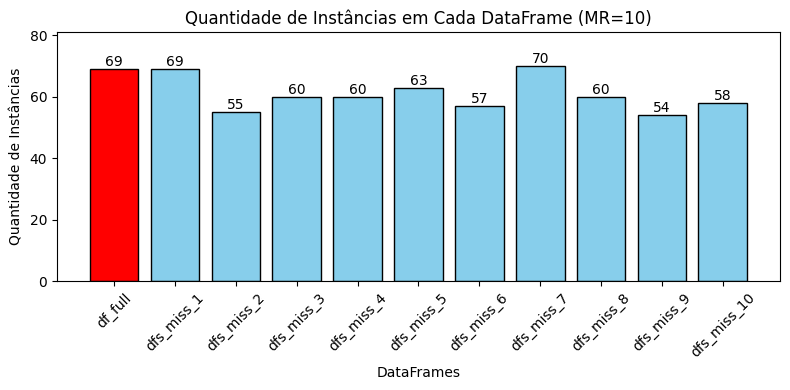

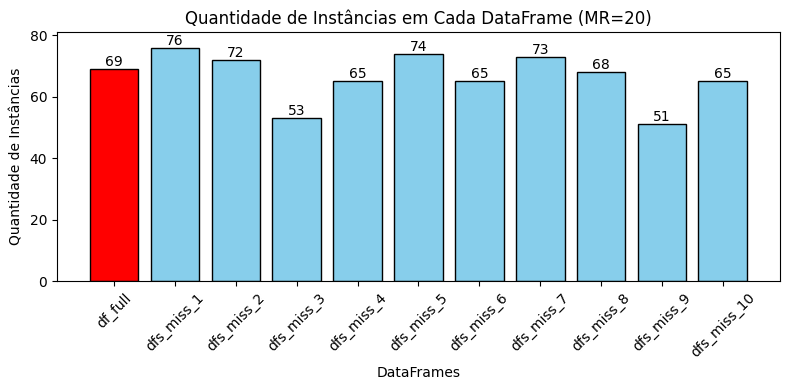

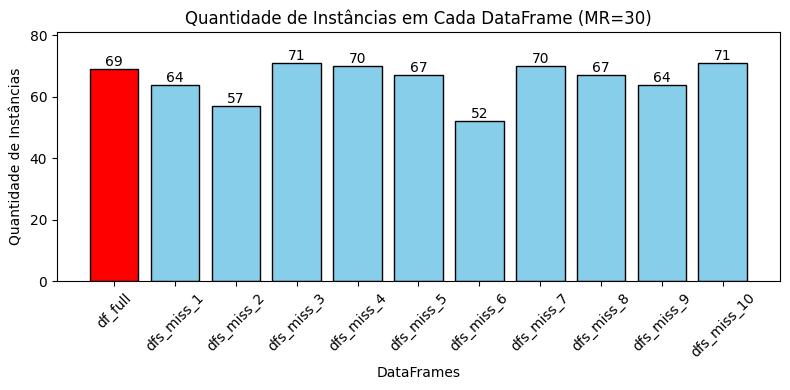

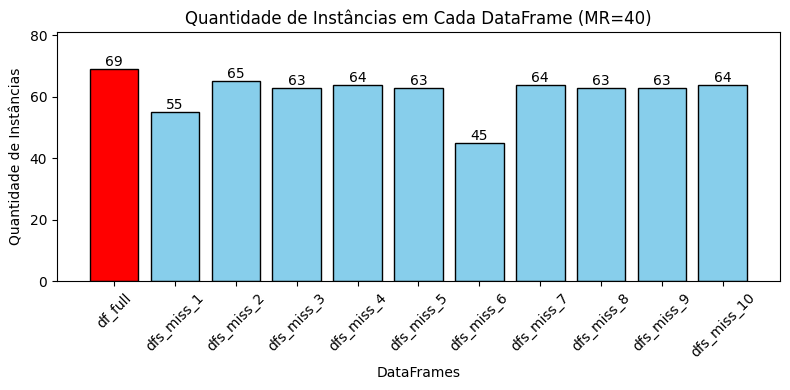

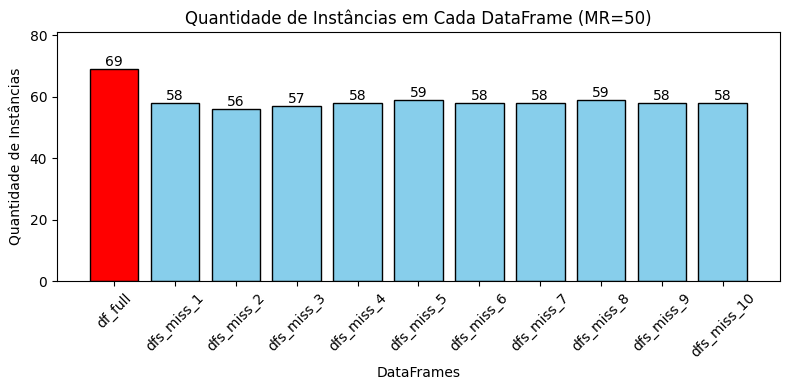

In [39]:
# Determinar o limite máximo para o eixo Y
max_instances = max(len(df_full), max(len(dfs[i]) for dfs in dfs_miss.values() for i in dfs.keys()))

# Criar um gráfico de barras para cada MR
for mr_value, dfs in dfs_miss.items():
    plt.figure(figsize=(8, 4))
    
    # Adicionar o tamanho de df_full ao dicionário de tamanhos
    sizes = {'df_full': len(df_full)}  # Tamanho de df_full
    sizes.update({f'dfs_miss_{i}': len(dfs[i]) for i in dfs.keys()})
    
    # Definir as cores das barras
    colors = ['red' if key == 'df_full' else 'skyblue' for key in sizes.keys()]
    
    # Criar as barras
    bars = plt.bar(sizes.keys(), sizes.values(), color=colors, edgecolor='black')

    # Adicionar os valores em cima das barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

    # Configurar o título e os rótulos
    plt.title(f'Quantidade de Instâncias em Cada DataFrame (MR={mr_value})')
    plt.xlabel('DataFrames')
    plt.ylabel('Quantidade de Instâncias')
    plt.xticks(rotation=45)
    
    # Definir o mesmo limite para o eixo Y
    plt.ylim(0, max_instances + 5)

    # Ajustar o layout
    plt.tight_layout()
    plt.show()


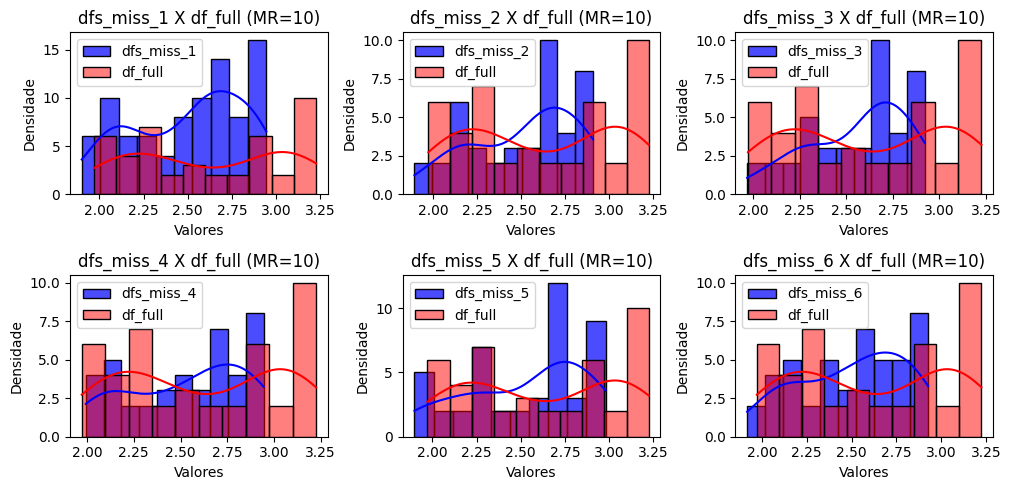

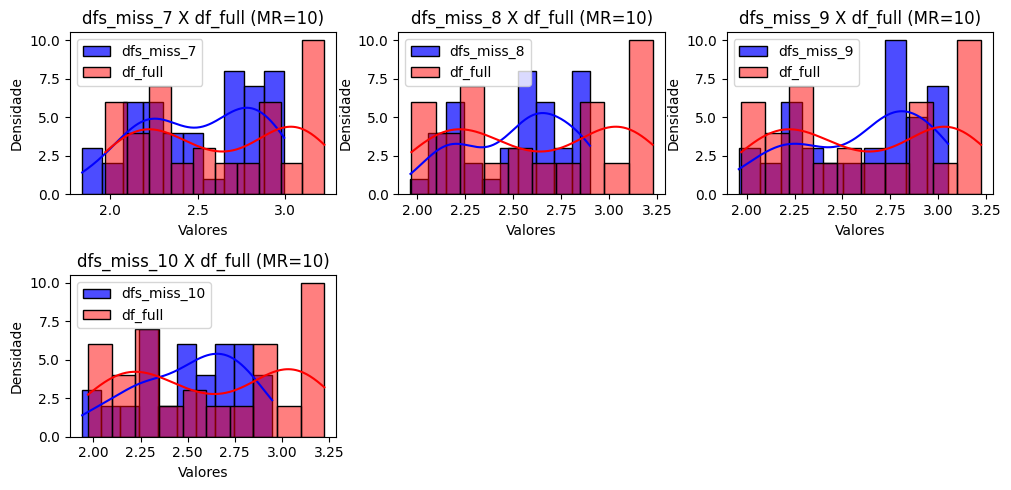

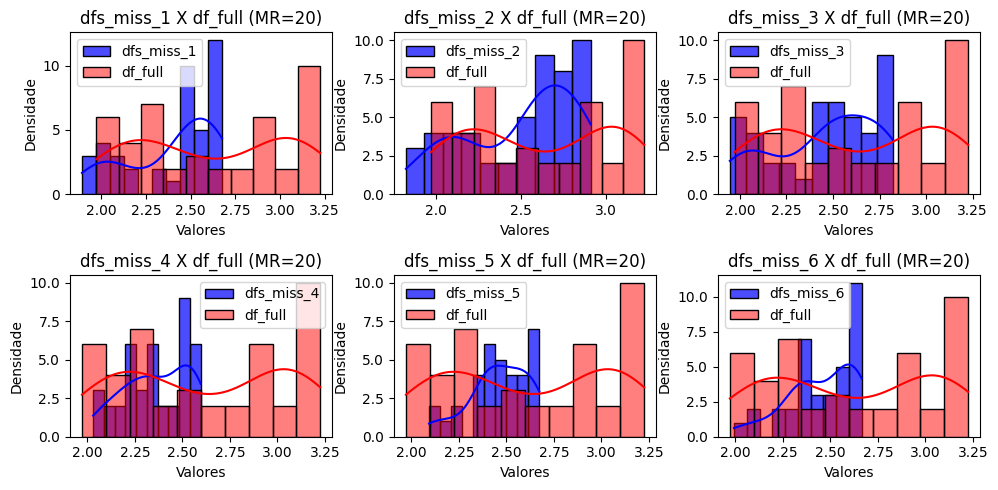

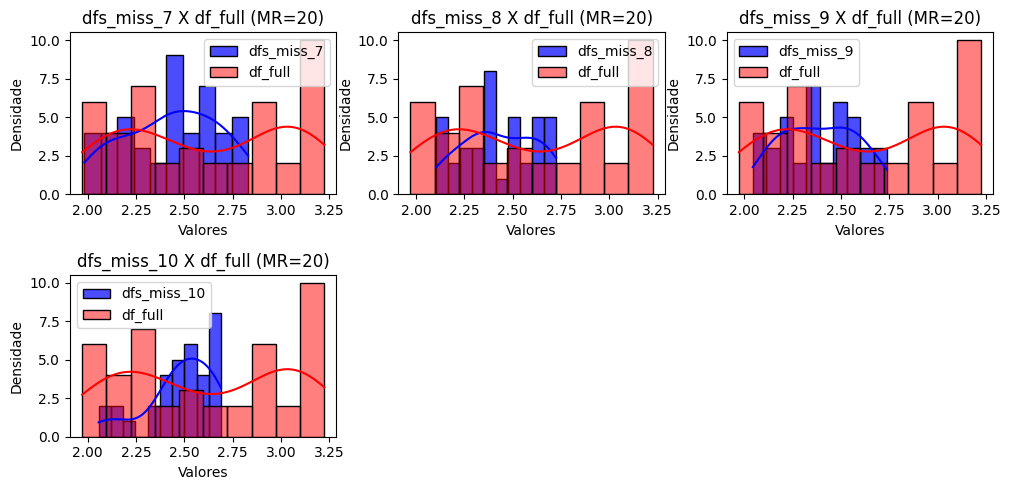

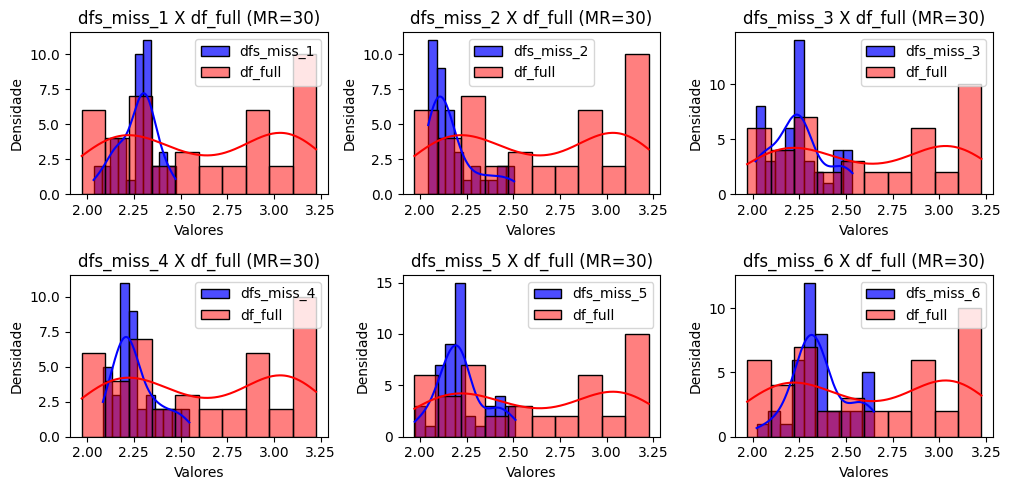

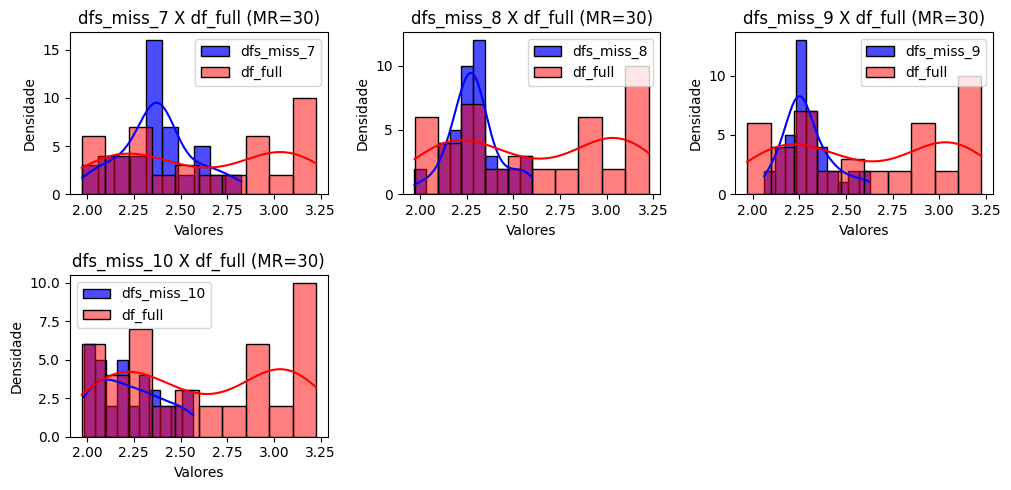

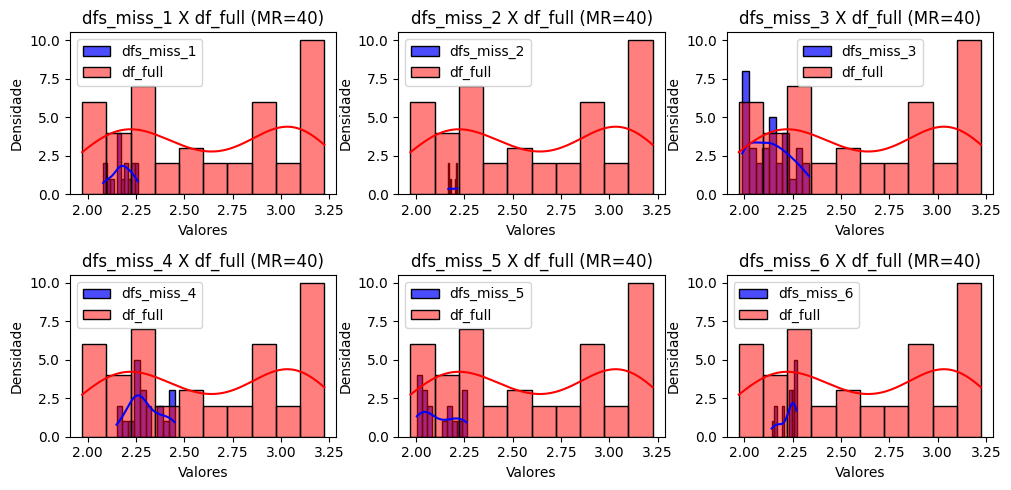

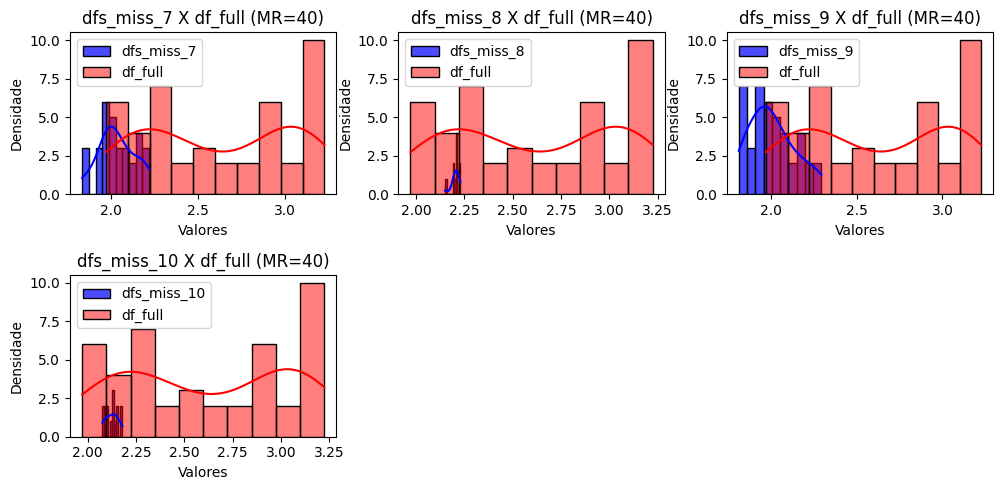

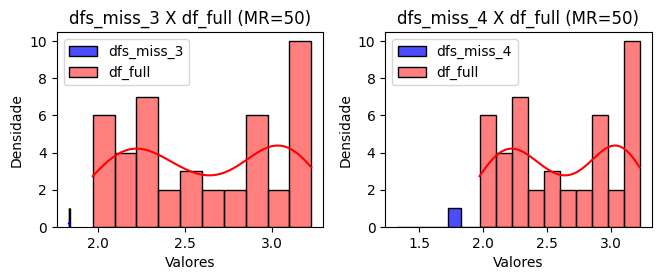

In [31]:
# Lista de valores de MR para variar


# Loop para gerar histogramas para cada valor de MR
for mr in mr_values:
    
    # Dividir os histogramas de dfs_miss em múltiplas figuras, se necessário
    num_subplots = 6  # Número máximo de subplots por figura
    dfs_miss_items = list(dfs_miss[mr].items())
    num_figures = (len(dfs_miss_items) + num_subplots - 1) // num_subplots  # Calcular o número de figuras necessárias
    
    for fig_idx in range(num_figures):
        plt.figure(figsize=(10, 5))
        
        # Adicionar os histogramas de dfs_miss e df_full
        start_idx = fig_idx * num_subplots
        end_idx = start_idx + num_subplots
        for subplot_idx, (i, df_miss) in enumerate(dfs_miss_items[start_idx:end_idx], start=1):
            plt.subplot(2, 3, subplot_idx)
            sns.histplot(df_miss.iloc[:, 0], bins=10, kde=True, color='blue', edgecolor='black', alpha=0.7, label=f'dfs_miss_{i}')
            sns.histplot(df_full.iloc[:, 0], bins=10, kde=True, color='red', edgecolor='black', alpha=0.5, label='df_full')
            plt.title(f'dfs_miss_{i} X df_full (MR={mr})')
            plt.xlabel('Valores')
            plt.ylabel('Densidade')
            plt.legend()
        
        # Ajustar o layout e mostrar os gráficos
        plt.tight_layout()
        plt.show()


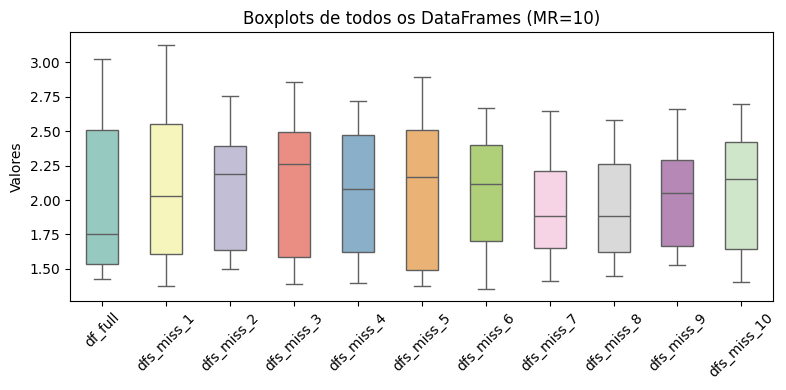

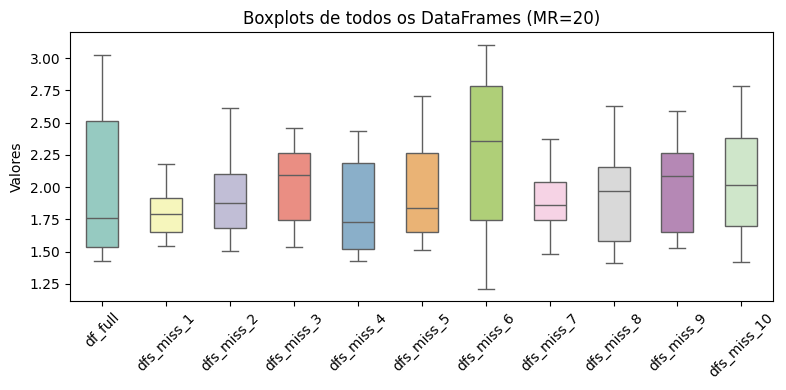

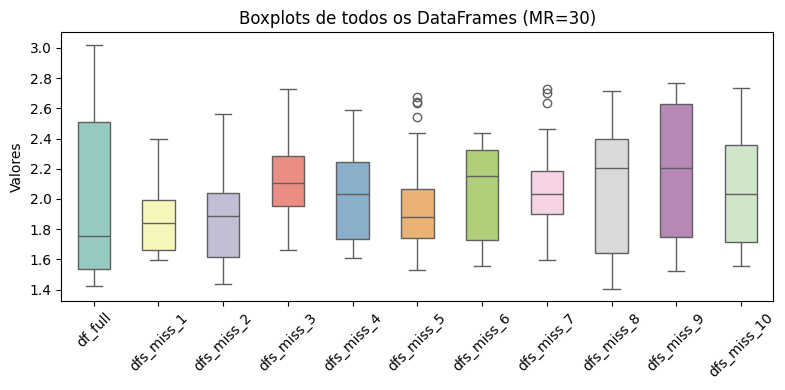

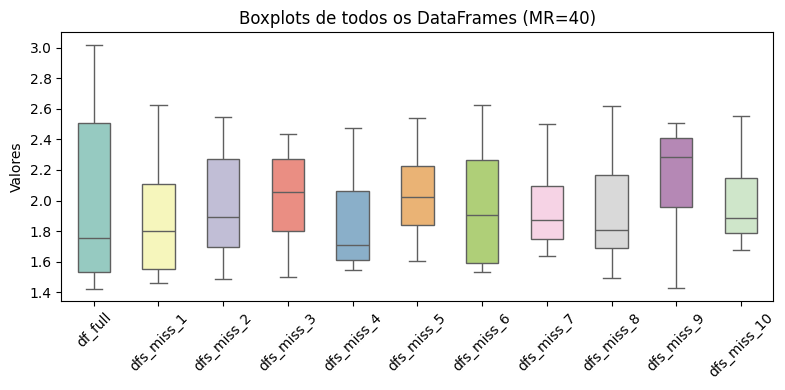

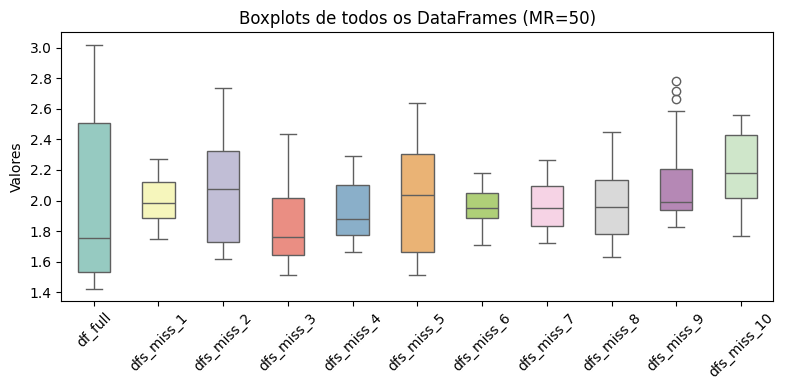

In [40]:
# Loop para gerar boxplots para cada valor de MR
for mr in mr_values:
    # Obter os dados de df_full e dfs_miss para o MR atual
    data = [df_full.iloc[:, 0].values] + [df.iloc[:, 0].values for df in dfs_miss[mr].values()]
    
    # Criar os rótulos correspondentes
    labels = ['df_full'] + [f'dfs_miss_{i}' for i in dfs_miss[mr].keys()]
    
    # Criar o boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=data, palette='Set3', width=0.5)
    
    # Ajustar o título e os rótulos
    plt.title(f'Boxplots de todos os DataFrames (MR={mr})')
    plt.ylabel('Valores')
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()


In [41]:
# Realizar o teste de Kolmogorov-Smirnov para todos os valores de MR
for mr, dfs in dfs_miss.items():
    # Inicializar contadores para cada MR
    rejeitaram = 0
    aceitaram = 0
    
    print(f"Resultados do teste de Kolmogorov-Smirnov (KS) para MR={mr}:")
    
    # Aplicar o teste de Kolmogorov-Smirnov para cada DataFrame em dfs_miss[mr]
    for key, df_miss in dfs.items():
        ks_stat, ks_p_value = scipy.stats.kstest(df_full.iloc[:, 0], df_miss.iloc[:, 0], alternative='two-sided')
        
        # Exibir os resultados detalhados para cada DataFrame
        print(f"  dfs_miss[{key}]:")
        print(f"    Estatística KS: {ks_stat}")
        print(f"    Valor-p: {ks_p_value}")
        
        if ks_p_value > 0.01:
            print("    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).")
            aceitaram += 1
        else:
            print("    Rejeitamos a hipótese nula (as distribuições são diferentes).")
            rejeitaram += 1
        print()
    
    # Calcular porcentagens para o MR atual
    total = rejeitaram + aceitaram
    porcentagem_rejeitaram = (rejeitaram / total) * 100
    porcentagem_aceitaram = (aceitaram / total) * 100
    
    # Exibir resumo final para o MR atual
    print(f"Resumo final para MR={mr}:")
    print(f"  As distribuições são diferentes: {rejeitaram} ({porcentagem_rejeitaram:.2f}%)")
    print(f"  As distribuições são semelhantes: {aceitaram} ({porcentagem_aceitaram:.2f}%)")
    print()

Resultados do teste de Kolmogorov-Smirnov (KS) para MR=10:
  dfs_miss[1]:
    Estatística KS: 0.2028985507246377
    Valor-p: 0.11689366527741817
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).

  dfs_miss[2]:
    Estatística KS: 0.2711462450592885
    Valor-p: 0.016754194511771955
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).

  dfs_miss[3]:
    Estatística KS: 0.21739130434782608
    Valor-p: 0.07989497902866026
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).

  dfs_miss[4]:
    Estatística KS: 0.26811594202898553
    Valor-p: 0.015438184740466501
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).

  dfs_miss[5]:
    Estatística KS: 0.14699792960662525
    Valor-p: 0.4231380485865741
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes)

In [11]:
# Realizar o teste de Mann-Whitney U para todos os valores de MR
for mr, dfs in dfs_miss.items():
    # Inicializar contadores para cada MR
    rejeitaram = 0
    aceitaram = 0
    
    print(f"Resultados do teste de Mann-Whitney U para MR={mr}:")
    
    # Aplicar o teste de Mann-Whitney U para cada DataFrame em dfs_miss[mr]
    for key, df_miss in dfs.items():
        u_stat, p_value = scipy.stats.mannwhitneyu(df_full.iloc[:, 0], df_miss.iloc[:, 0], alternative='two-sided')
        
        # Exibir os resultados detalhados para cada DataFrame
        print(f"  dfs_miss[{key}]:")
        print(f"    Estatística U: {u_stat}")
        print(f"    Valor-p: {p_value}")
        
        if p_value > 0.05:
            print("    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).")
            aceitaram += 1
        else:
            print("    Rejeitamos a hipótese nula (as distribuições são diferentes).")
            rejeitaram += 1
        print()
    
    # Calcular porcentagens para o MR atual
    total = rejeitaram + aceitaram
    porcentagem_rejeitaram = (rejeitaram / total) * 100
    porcentagem_aceitaram = (aceitaram / total) * 100
    
    # Exibir resumo final para o MR atual
    print(f"Resumo final para MR={mr}:")
    print(f"  As distribuições são diferentes: {rejeitaram} ({porcentagem_rejeitaram:.2f}%)")
    print(f"  As distribuições são semelhantes: {aceitaram} ({porcentagem_aceitaram:.2f}%)")
    print()

Resultados do teste de Mann-Whitney U para MR=10:
  dfs_miss[1]:
    Estatística U: 2310.0
    Valor-p: 0.07137717316794034
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).

  dfs_miss[2]:
    Estatística U: 1098.0
    Valor-p: 0.1983806609017007
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).

  dfs_miss[3]:
    Estatística U: 1015.0
    Valor-p: 0.43429728098802267
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).

  dfs_miss[4]:
    Estatística U: 1070.0
    Valor-p: 0.2087455352348453
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).

  dfs_miss[5]:
    Estatística U: 1193.0
    Valor-p: 0.20810889028477897
    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).

  dfs_miss[6]:
    Estatística U: 1194.0
    Valor-p: 0.14291753326975018
   

In [14]:
# Realizar o teste de Levene para todos os valores de MR
for mr, dfs in dfs_miss.items():
    # Inicializar contadores para cada MR
    rejeitaram = 0
    aceitaram = 0
    
    print(f"Resultados do teste de Levene para MR={mr}:")
    
    # Aplicar o teste de Levene para cada DataFrame em dfs_miss[mr]
    for key, df_miss in dfs.items():
        stat, p_value = scipy.stats.levene(df_full.iloc[:, 0], df_miss.iloc[:, 0])
        
        # Exibir os resultados detalhados para cada DataFrame
        print(f"  dfs_miss[{key}]:")
        print(f"    Estatística: {stat}")
        print(f"    Valor-p: {p_value}")
        
        if p_value > 0.05:
            print("    Não há evidências suficientes para rejeitar a hipótese nula (as variâncias são semelhantes).")
            aceitaram += 1
        else:
            print("    Rejeitamos a hipótese nula (as variâncias são diferentes).")
            rejeitaram += 1
        print()
    
    # Calcular porcentagens para o MR atual
    total = rejeitaram + aceitaram
    porcentagem_rejeitaram = (rejeitaram / total) * 100
    porcentagem_aceitaram = (aceitaram / total) * 100
    
    # Exibir resumo final para o MR atual
    print(f"Resumo final para MR={mr}:")
    print(f"  As variâncias são diferentes: {rejeitaram} ({porcentagem_rejeitaram:.2f}%)")
    print(f"  As variâncias são semelhantes: {aceitaram} ({porcentagem_aceitaram:.2f}%)")
    print()


Resultados do teste de Levene para MR=10:
  dfs_miss[1]:
    Estatística: 12.137402157073945
    Valor-p: 0.0006740190948386453
    Rejeitamos a hipótese nula (as variâncias são diferentes).

  dfs_miss[2]:
    Estatística: 12.731020987662157
    Valor-p: 0.0005940615791656358
    Rejeitamos a hipótese nula (as variâncias são diferentes).

  dfs_miss[3]:
    Estatística: 21.36406209139102
    Valor-p: 1.3603201732737042e-05
    Rejeitamos a hipótese nula (as variâncias são diferentes).

  dfs_miss[4]:
    Estatística: 11.027827414481006
    Valor-p: 0.0013297316475092563
    Rejeitamos a hipótese nula (as variâncias são diferentes).

  dfs_miss[5]:
    Estatística: 5.738490088764606
    Valor-p: 0.01869220752938909
    Rejeitamos a hipótese nula (as variâncias são diferentes).

  dfs_miss[6]:
    Estatística: 14.75206757357047
    Valor-p: 0.00023079123741599322
    Rejeitamos a hipótese nula (as variâncias são diferentes).

  dfs_miss[7]:
    Estatística: 7.329439573938254
    Valor-p

In [57]:
# Dicionário para armazenar os resultados
wasserstein_results = {}

# Realizar o cálculo da distância de Wasserstein para todos os valores de MR
for mr, dfs in dfs_miss.items():
    wasserstein_results[mr] = {}
    print(f"Resultados da distância de Wasserstein para MR={mr}:")
    
    # Calcular a distância de Wasserstein para cada DataFrame em dfs_miss[mr]
    for key, df_miss in dfs.items():
        distance = scipy.stats.wasserstein_distance(df_full.iloc[:, 0], df_miss.iloc[:, 0])
        wasserstein_results[mr][key] = distance  # Armazenar o valor no dicionário
        
        # Exibir os resultados detalhados para cada DataFrame
        print(f"  dfs_miss[{key}]:")
        print(f"    Distância de Wasserstein: {distance}")
        print()

Resultados da distância de Wasserstein para MR=10:
  dfs_miss[1]:
    Distância de Wasserstein: 0.09298455919797866

  dfs_miss[2]:
    Distância de Wasserstein: 0.19444825298902518

  dfs_miss[3]:
    Distância de Wasserstein: 0.15574211825585815

  dfs_miss[4]:
    Distância de Wasserstein: 0.15868505730855093

  dfs_miss[5]:
    Distância de Wasserstein: 0.11502083078777588

  dfs_miss[6]:
    Distância de Wasserstein: 0.18262276237057476

  dfs_miss[7]:
    Distância de Wasserstein: 0.1918788306641353

  dfs_miss[8]:
    Distância de Wasserstein: 0.166585891288194

  dfs_miss[9]:
    Distância de Wasserstein: 0.22174797584434833

  dfs_miss[10]:
    Distância de Wasserstein: 0.1734260601319466

Resultados da distância de Wasserstein para MR=20:
  dfs_miss[1]:
    Distância de Wasserstein: 0.33600664251471496

  dfs_miss[2]:
    Distância de Wasserstein: 0.24392097821998604

  dfs_miss[3]:
    Distância de Wasserstein: 0.2783409914476622

  dfs_miss[4]:
    Distância de Wasserstein:

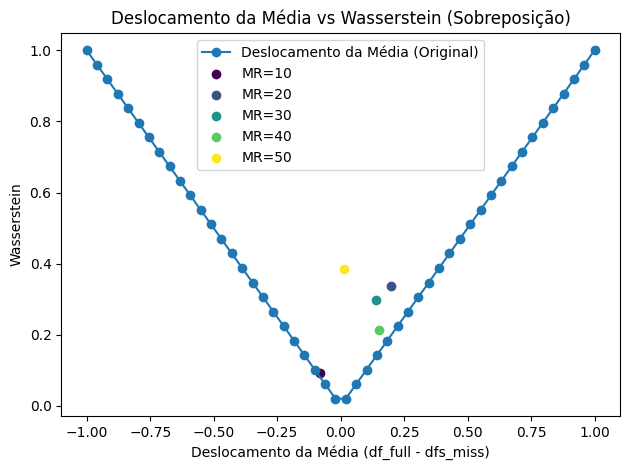

In [78]:
import numpy as np

# Referência: coluna original
original = df_full.values.ravel()

# Variações de média que vamos testar
mean_shifts = np.linspace(-1, 1, 50)
distances = []

for shift in mean_shifts:
    # Criar nova coluna artificial com média deslocada
    shifted = original + shift
    
    # Calcular Wasserstein Distance
    dist = scipy.stats.wasserstein_distance(original, shifted)
    distances.append(dist)

# Obter o deslocamento da média de cada dfs_miss em relação ao df_full para o eixo X
x_values = [df_full.iloc[:, 0].mean() - list(mr_dfs.values())[0].iloc[:, 0].mean() for mr_dfs in dfs_miss.values()]

# Obter os valores de Wasserstein do primeiro dfs_miss para o eixo Y
y_values = [list(results.values())[0] for results in wasserstein_results.values()]

# Garantir que x_values e y_values tenham o mesmo tamanho
min_length = min(len(x_values), len(y_values))
x_values = x_values[:min_length]
y_values = y_values[:min_length]

# Criar um mapa de cores para os valores de MR
colors = plt.cm.viridis(np.linspace(0, 1, len(mr_values)))

# Plotar os dados existentes
plt.plot(mean_shifts, distances, marker='o', label='Deslocamento da Média (Original)')

# Adicionar os novos pontos ao gráfico
for i, mr in enumerate(mr_values[:min_length]):
    plt.scatter(x_values[i], y_values[i], color=colors[i], label=f'MR={mr}')

# Configurar o título e os rótulos
plt.title('Deslocamento da Média vs Wasserstein (Sobreposição)')
plt.xlabel('Deslocamento da Média (df_full - dfs_miss)')
plt.ylabel('Wasserstein')
plt.legend()

# Ajustar o layout e exibir
plt.tight_layout()
plt.show()
